## Setup

In [1]:
import os
import sys
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!cp -r /kaggle/input/benetech-code-v2/src ./
!cp -r /kaggle/input/benetech-code-v2/yolox/ ./
!mv yolox YOLOX  #

In [3]:
import os
if len(os.listdir("/kaggle/input/benetech-making-graphs-accessible/test/images/")) == 5:
    !mkdir test
    !cp /kaggle/input/benetech-making-graphs-accessible/test/images/* test
    !cp /kaggle/input/benetech-weights/dots/1_svg.jpg test

#### YoloX

In [4]:
!mkdir -p /tmp/pip/cache/
!cp /kaggle/input/yolox-whl/* /tmp/pip/cache/

In [5]:
!pip install -qqq --no-index /kaggle/input/yolox-whl/loguru-0.7.0-py3-none-any.whl
!pip install -qqq --no-index /kaggle/input/yolox-whl/thop-0.1.1.post2209072238-py3-none-any.whl
!pip install -qqq --no-index /kaggle/input/yolox-whl/protobuf-4.23.2-cp37-abi3-manylinux2014_x86_64.whl
!pip install -qqq --no-index /kaggle/input/yolox-whl/onnx-1.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -qqq --no-index /kaggle/input/yolox-whl/onnx_simplifier-0.4.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -qqq --no-index /kaggle/input/yolox-whl/Cython-0.29.35-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl
!pip install -qqq /kaggle/input/cached/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.1 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.1 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
dask-cudf 23.4.1 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.23.2 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 10.0.1 which is incompatible.
cudf 23.4.1 requires protobuf<4.22,>=4.21.6, but you have protobuf 4.23.2 which is incompatible.
cuml 23.4.1 requires dask==2023.3.2, but you have dask 2023.5.0 which is incompatible.
dask-cudf 23.4.1 requires dask==2023.3.2, but you have dask 2023.5.0 which is incompatible.
google-api-core 

In [6]:
cd /kaggle/working

/kaggle/working


### Cached

In [7]:
!pip install -q --no-index --find-links=file:///kaggle/input/cached addict terminaltables pycocotools mmcv_full mmdet

## Classification

In [8]:
%%writefile inf_main.py

import glob
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader

from data.dataset import ClsDataset
from data.transforms import get_transfos
from model_zoo.models import define_model
from util.torch import load_model_weights
from util.metrics import accuracy


NUM_WORKERS = 2


def predict(model, dataset, loss_config, batch_size=64, device="cuda", use_fp16=False):
    """
    Perform model inference on a dataset.

    Args:
        model (nn.Module): Trained model for inference.
        dataset (Dataset): Dataset to perform inference on.
        loss_config (dict): Loss configuration.
        batch_size (int, optional): Batch size for inference. Defaults to 64.
        device (str, optional): Device to use for inference. Defaults to "cuda".
        use_fp16 (bool, optional): Whether to use mixed precision inference. Defaults to False.

    Returns:
        preds (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).
        preds_aux (numpy.ndarray): Auxiliary predictions of shape (num_samples, num_aux_classes).
    """
    model.eval()
    preds = np.empty((0, model.num_classes))
    preds_aux = []

    loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    with torch.no_grad():
        for img, _, _ in tqdm(loader):
            with torch.cuda.amp.autocast(enabled=use_fp16):
                pred, pred_aux = model(img.cuda())

            # Get probabilities
            if loss_config["activation"] == "sigmoid":
                pred = pred.sigmoid()
            elif loss_config["activation"] == "softmax":
                pred = pred.softmax(-1)

            if loss_config.get("activation_aux", "softmax") == "sigmoid":
                pred_aux = pred_aux.sigmoid()
            elif loss_config.get("activation_aux", "softmax") == "softmax":
                pred_aux = pred_aux.softmax(-1)

            preds = np.concatenate([preds, pred.cpu().numpy()])
            preds_aux.append(pred_aux.cpu().numpy())

    return preds, np.concatenate(preds_aux)


class Config:
    """
    Placeholder to load a config from a saved json
    """

    def __init__(self, dic):
        for k, v in dic.items():
            setattr(self, k, v)


def kfold_inference(
    df,
    exp_folder,
    debug=False,
    use_tta=False,
    use_fp16=False,
):
    """
    Perform k-fold cross-validation for model inference on the validation set.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        exp_folder (str): Path to the experiment folder.
        debug (bool, optional): Whether to run in debug mode. Defaults to False.
        save (bool, optional): Whether to save the predictions. Defaults to True.
        use_tta (bool, optional): Whether to use test time augmentation. Defaults to False.
        use_fp16 (bool, optional): Whether to use mixed precision inference. Defaults to False.
        train (bool, optional): Whether to perform inference on the training set. Defaults to False.
        use_mt (bool, optional): Whether to use model teacher. Defaults to False.
        distilled (bool, optional): Whether to use distilled model. Defaults to False.
        n_soup (int, optional): Number of models to use for model soup. Defaults to 0.

    Returns:
        np.ndarray: Array containing the predicted probabilities for each class.
    """
    assert not use_tta, "TTA not implemented"
    predict_fct = predict  # predict_tta if use_tta else predict

    config = Config(json.load(open(exp_folder + "config.json", "r")))

    model = define_model(
        config.name,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        n_channels=config.n_channels,
        drop_rate=config.drop_rate,
        drop_path_rate=config.drop_path_rate,
        use_gem=config.use_gem,
        reduce_stride=config.reduce_stride,
        verbose=(config.local_rank == 0),
        pretrained=False,
    )
    model = model.cuda().eval()

    preds = []
    for weights in glob.glob(exp_folder + f"{config.name}_fullfit_*"):
        print(weights)
        model = load_model_weights(model, weights, verbose=1)

        dataset = ClsDataset(
            df,
            transforms=get_transfos(augment=False, resize=config.resize),
        )

        pred, _ = predict_fct(
            model,
            dataset,
            config.loss_config,
            batch_size=8,
            use_fp16=use_fp16,
        )

        if df['target'].max():
            acc = accuracy(df["target"].values, pred)
            print(f"\n -> Accuracy : {acc:.4f}")
        
        preds.append(pred)

    return np.mean(preds, 0)


Writing inf_main.py


In [9]:
%%python

import sys
sys.path.append('/kaggle/working/src/')
sys.path.append('/kaggle/input/timm-0-6-9/pytorch-image-models-master')

import os
import re
import glob
import timm
import numpy as np
import pandas as pd

from params import CLASSES
from inf_main import kfold_inference


DATA_PATH = "/kaggle/input/benetech-making-graphs-accessible/"

images = glob.glob(DATA_PATH + 'test/images/*.jpg')
if len(images) == 5:
    images = glob.glob('/kaggle/working/test/*')

if len(images) > 0:  # 6 to infer val
    df = pd.DataFrame({"path": images})
    df['target'] = 0
else:
    df = pd.read_csv('/kaggle/input/benetech-weights/cls/33/df_val.csv')
    df = df[df['chart-type'] != "dot"].reset_index(drop=True)
    df['path'] = df['path'].apply(lambda x: re.sub('../input/../input/', DATA_PATH, x))

EXP_FOLDERS = [
    "/kaggle/input/benetech-weights/cls/2023-06-08_6/",
    "/kaggle/input/benetech-weights/cls/2023-06-08_7/",
]

preds = []
for exp_folder in EXP_FOLDERS:
    pred = kfold_inference(df, exp_folder)
    preds.append(pred)

pred = np.mean(preds, 0)
pred = pred.argmax(-1)
df['pred'] = pred
df['chart-type'] = df['pred'].apply(lambda x: CLASSES[x])
df['id'] = df['path'].apply(lambda x: x[:-4].split('/')[-1])
df.to_csv('pred_cls.csv', index=False)
print('\n-> Saved results to pred_cls.csv')

/kaggle/input/benetech-weights/cls/2023-06-08_6/eca_nfnet_l2_fullfit_1.pt

 -> Loading encoder weights from /kaggle/input/benetech-weights/cls/2023-06-08_6/eca_nfnet_l2_fullfit_1.pt



100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


/kaggle/input/benetech-weights/cls/2023-06-08_6/eca_nfnet_l2_fullfit_0.pt

 -> Loading encoder weights from /kaggle/input/benetech-weights/cls/2023-06-08_6/eca_nfnet_l2_fullfit_0.pt



100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


/kaggle/input/benetech-weights/cls/2023-06-08_7/eca_nfnet_l2_fullfit_1.pt

 -> Loading encoder weights from /kaggle/input/benetech-weights/cls/2023-06-08_7/eca_nfnet_l2_fullfit_1.pt



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


/kaggle/input/benetech-weights/cls/2023-06-08_7/eca_nfnet_l2_fullfit_0.pt

 -> Loading encoder weights from /kaggle/input/benetech-weights/cls/2023-06-08_7/eca_nfnet_l2_fullfit_0.pt



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]



-> Saved results to pred_cls.csv


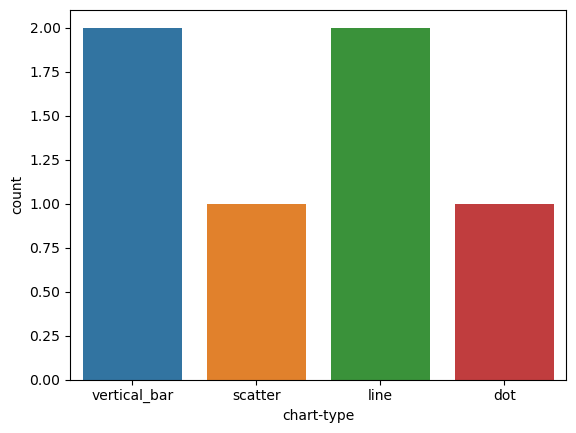

,path,target,pred,chart-type,id
0,/kaggle/working/test/01b45b831589.jpg,0,0,vertical_bar,01b45b831589
1,/kaggle/working/test/00f5404753cf.jpg,0,3,scatter,00f5404753cf
2,/kaggle/working/test/00dcf883a459.jpg,0,0,vertical_bar,00dcf883a459
3,/kaggle/working/test/000b92c3b098.jpg,0,2,line,000b92c3b098
4,/kaggle/working/test/007a18eb4e09.jpg,0,2,line,007a18eb4e09
5,/kaggle/working/test/1_svg.jpg,0,1,dot,1_svg


In [10]:
import sys
sys.path.append('/kaggle/working/src/')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from params import CLASSES
from util.plots import plot_confusion_matrix

df = pd.read_csv('pred_cls.csv')

if df['target'].max():    
    plot_confusion_matrix(df['pred'], df['target'], display_labels=CLASSES, normalize=None)
    plt.xticks(rotation=45)
    plt.title(f"Acc = {(df['pred'] == df['target']).mean() :.4f}")
    plt.show()
else:
    sns.countplot(x=df['chart-type'])
    plt.show()
    
df.head(10)

## Dots

In [11]:
%%writefile dot_cfg.py

class ConfigDot:
    selected_model = "yolo"
    bbox_format = "yolo"
    pred_format = "pascal_voc"

    name = "benetech_1_m_1"
    
    cfg = "/kaggle/input/benetech-yolox-weights/yolox_m/benetech_1_m_1.py"
    ckpt = "/kaggle/input/benetech-yolox-weights/yolox_m/best_ckpt.pth"

    version = "v13"
    labels = ["point"]

    size = (1024, 1024)

    # NMS
    conf_thresh = 0.05
    iou_thresh = 0.1
    max_per_img = 500
    min_per_img = 1
    
    val_bs = 1  # if size[0] > 1024 else 16
    device = "cuda"
    
config_marker = ConfigDot

Writing dot_cfg.py


In [12]:
%%python

import sys
sys.path.append('/kaggle/working/src/')
sys.path.append('/kaggle/working/YOLOX/')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import re
import cv2
import sys
import glob
import torch
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel
from mmdet.apis import init_detector, inference_detector

from util.ocr import ocr
from util.plots import plot_results
from util.metrics import score_series

from inference.yolox import retrieve_yolox_model, predict, YoloXWrapper
from inference.utils import get_transfos, InferenceDataset

from post_process.retrieve import retrieve_missing_boxes
from post_process.in_graph import post_process_preds_dots
from post_process.dots import constraint_size, restrict_labels_x, assign_dots, cluster_on_x

from dot_cfg import config_marker


transformers.utils.logging.set_verbosity_error()


# Data
print('- Prepare data')

df_target = pd.read_csv('/kaggle/input/benetech-weights/y_train.csv')
df = pd.read_csv('/kaggle/working/pred_cls.csv')

if len(df) > 0:  # 6 for dot val
    df = df[df['chart-type'] == "dot"].reset_index(drop=True)
    df['gt_path'] = ""
else:
    df_test = pd.DataFrame({"path": glob.glob('/kaggle/input/benetech-weights/dots/*')})
    df_test['id'] = df_test['path'].apply(lambda x: Path(x).stem)
    df_test['source'] = "extracted"
    df_test['chart-type'] = "dot"
    df_test['gt_path'] = ""
    df_test.to_csv('df_test_dot.csv', index=False)
    df = df_test
    df_target = pd.read_csv("/kaggle/input/benetech-weights/dot_labels.csv")

transforms = get_transfos(size=config_marker.size)
dataset = InferenceDataset(df, transforms, pad=True)


# Dot inf
print('- Dot inference')

assert os.path.exists(config_marker.ckpt), "Weights do not exist"
assert os.path.exists(config_marker.cfg), "Config does not exist"
    
if len(dataset):
    model = retrieve_yolox_model(config_marker.cfg, config_marker.ckpt)
    model = YoloXWrapper(model, config_marker)
    meter, _ = predict(model, dataset, config_marker)
    dataset = InferenceDataset(df, None)


# Cached
print('- Retrieve CACHED model')
wdir = '/kaggle/input/cached/work_dirs'
config_file = '/kaggle/input/benetech-weights/custom.py'
checkpoint_file = wdir + '/cascade_rcnn_swin-t_fpn_LGF_VCE_PCE_coco_focalsmoothloss/checkpoint.pth'
if len(dataset):
    cached_model = init_detector(config_file, checkpoint_file, device='cuda')


# OCR
print('- Prepare OCR model')

if len(dataset):
    processor = TrOCRProcessor.from_pretrained("/kaggle/input/benetech-weights/ocr/")
    config = torch.load("/kaggle/input/benetech-weights/ocr/config.pth")
    ocr_model = VisionEncoderDecoderModel(config)
    ocr_model.load_state_dict(torch.load('/kaggle/input/benetech-weights/ocr/pytorch_model.bin'))
    ocr_model = ocr_model.cuda().eval()

    
# Loop
print('\n -> Done ! Starting loop...\n')
PLOT = len(dataset) < 5

scores, preds_x, preds_y = [], {}, {}
for idx in range(len(dataset)):
    try:
        # Load image & update shape
        img, gt, shape = dataset[idx]
        if img.shape[1] > img.shape[0] * 1.4:
    #         padding = img.shape[0] // 2
            padding = int(img.shape[1] * 0.9) - img.shape[0]
        else:
            padding = 0
        meter.preds[idx].update_shape((img.shape[0] + padding, img.shape[1]))
        
        # Cached
        cached_result = inference_detector(cached_model, dataset.paths[idx])  # list[array]
        score_th = min(0.1, cached_result[4][2, 4])

        img, gt, shape = dataset[idx]

        id_ = df.id[idx]

        print(idx, id_[:10], end="\t")
        title = f"{id_}"

        # Preds
        preds_ = [meter.preds[idx]['pascal_voc'][meter.labels[idx] == 0] for i in range(1)][0]
        preds = [[], [], [], preds_]

        # Override with cached
        preds[1] = cached_result[4][cached_result[4][:, -1] > score_th][:, :4].astype(int)
        preds[0] = cached_result[2][:1, :4].astype(int)

        preds = post_process_preds_dots(preds, margin_pt=5, margin_text=5)
#         preds[-1] = constraint_size(preds[-1], margin=2, coef=0.2)

        margin = (img.shape[0] + img.shape[1]) / (2 * 20)
        preds = restrict_labels_x(preds, margin=margin)

        # Visual similarity
        try:
            retrieved_boxes = retrieve_missing_boxes(
                preds, img, verbose=False, min_sim=0.85, seed=100, hw=None, max_retrieved=20, margin=-1
            )
            if len(retrieved_boxes):
                print('RETRIEVED', len(retrieved_boxes), end="\t")
                preds[-1] = np.concatenate([preds[-1], retrieved_boxes])
        except:
            pass

        try:
            centers, clusters = cluster_on_x(preds[-1], shape[1], plot=False)
            centers = np.array([c for i, c in enumerate(centers) if clusters[i] > 0])
        except:
            centers, clusters = None, None

        if len(preds[1]):
            try:
                xlabels = preds[1]
                xlabels_loc = (xlabels[:, 0] + xlabels[:, 2]) / 2
        
                if centers is not None:
                    mapping, retrieved_xlabels = assign_dots(preds[1], centers, retrieve_missing=True)
                    if len(retrieved_xlabels):
                        xlabels = np.concatenate([xlabels, retrieved_xlabels])
                    xlabels_loc = (xlabels[:, 0] + xlabels[:, 2]) / 2
                    preds[1] = xlabels

                # OCR
                x_texts = ocr(ocr_model, processor, img, preds[1], margin=1, plot=False)

                xs, ys, locs = [], [], []
                for i, txt in enumerate(x_texts):
                    if clusters is not None:
                        if i in mapping.keys():
                            xs.append(txt)
                            locs.append(xlabels_loc[i])
                            ys.append(clusters.get(mapping[i], 0))
                        else:
                            if xlabels_loc[i] > preds[0][0][0]:
                                xs.append(txt)
                                locs.append(xlabels_loc[i])
                                ys.append(0)
                    else:
                        xs.append(txt)
                        locs.append(xlabels_loc[i])
                        ys.append(0)

            except:  # OCR or assignment fails, using dummy values
                print('Error')
                xs = [str(i) for i in range(len(centers))]
                locs = centers
                ys = list(clusters.values())
        else:
            xs = [str(i) for i in range(len(centers))]
            locs = centers
            ys = list(clusters.values())

        if PLOT:
            plot_results(img, preds, figsize=(12, 7), title=title)

        pred = pd.DataFrame({"x": xs, "y": np.array(ys).astype(int), "loc": locs})
        pred = pred.sort_values('loc').reset_index(drop=True)

        preds_x[id_] = ";".join(pred['x'].astype(str))
        preds_y[id_] = ";".join(pred['y'].astype(str))

        if df_target is not None:
            gt = df_target[df_target['id'] == id_].reset_index(drop=True)
            if len(gt):
                gt['y'] = gt["y"].astype(int)
                score_x = score_series(gt['x'].values, pred['x'].values)
                score_y = score_series(gt['y'].values, pred['y'].values)
                print(f"Scores  -  x: {score_x:.3f}  - y: {score_y:.3f}")
                scores += [score_x, score_y]
    except:
        pass

if len(scores):
    print(f'\n-> Dot CV : {np.mean(scores) :.3f}')
    
df['pred_x'] = df['id'].apply(lambda x: preds_x.get(x, ""))
df['pred_y'] = df['id'].apply(lambda x: preds_y.get(x, ""))

df.to_csv('df_dot_preds.csv', index=False)

print('\n\n-> Saved results to df_dot_preds.csv')

- Prepare data
- Dot inference
 -> Loading weights from /kaggle/input/benetech-yolox-weights/yolox_m/best_ckpt.pth
- Retrieve CACHED model
load checkpoint from local path: /kaggle/input/cached/work_dirs/cascade_rcnn_swin-t_fpn_LGF_VCE_PCE_coco_focalsmoothloss/checkpoint.pth
- Prepare OCR model

 -> Done ! Starting loop...

0 1_svg	

-> Saved results to df_dot_preds.csv


### To submission format

In [13]:
df = pd.read_csv('pred_cls.csv')[['path', 'chart-type', "id"]]

# Merge dot
df_dot = pd.read_csv('df_dot_preds.csv')
df_dot = df_dot[['id', 'pred_x', 'pred_y']]

df = df.merge(df_dot, on="id", how="left")

df['pred_x'] = df['pred_x'].fillna("")
df['pred_y'] = df['pred_y'].fillna("")

# Reformat & save
dfx = df[["id", "pred_x", "chart-type"]].copy()
dfx['id'] += "_x"
dfx.columns = ["id", "data_series", "chart_type"]

dfy = df[["id", "pred_y", "chart-type"]].copy()
dfy['id'] += "_y"
dfy.columns = ["id", "data_series", "chart_type"]

sub = pd.concat([dfx, dfy]).sort_values('id').reset_index(drop=True)

sub.to_csv('submission_dot.csv', index=False)
print('-> Saved results to submission_dot.csv')

display(sub[sub['chart_type'] == "dot"].head())
sub.head(20)

-> Saved results to submission_dot.csv


,id,data_series,chart_type
10,1_svg_x,2;3;4;5;6;7;8,dot
11,1_svg_y,4;5;0;7;1;0;2,dot


,id,data_series,chart_type
0,000b92c3b098_x,,line
1,000b92c3b098_y,,line
2,007a18eb4e09_x,,line
3,007a18eb4e09_y,,line
4,00dcf883a459_x,,vertical_bar
5,00dcf883a459_y,,vertical_bar
6,00f5404753cf_x,,scatter
7,00f5404753cf_y,,scatter
8,01b45b831589_x,,vertical_bar
9,01b45b831589_y,,vertical_bar


## Scatter

In [14]:
%%writefile scatter_cfg.py


class ConfigMarker:
    selected_model = "yolo"
    bbox_format = "yolo"
    pred_format = "pascal_voc"

    name = "benetech_1_m_1"
    cfg = "/kaggle/input/benetech-yolox-weights/yolox_m/benetech_1_m_1.py"
    ckpt = "/kaggle/input/benetech-yolox-weights/yolox_m/best_ckpt.pth"
    
    version = "v13"
#     version = "v13_sim"
    labels = ["point"]

    size = (1024, 1024)

    # NMS
    conf_thresh = 0.6
    iou_thresh = 0.4
    max_per_img = 500
    min_per_img = 1
    
    val_bs = 1  # if size[0] > 1024 else 16
    device = "cuda"
    
class ConfigMarker2:
    selected_model = "yolo"
    bbox_format = "yolo"
    pred_format = "pascal_voc"

    name = "benetech_1_l_1"
    cfg = "/kaggle/input/benetech-yolox-weights/yolox_l/benetech_1_l_1.py"
    ckpt = "/kaggle/input/benetech-yolox-weights/yolox_l/best_ckpt.pth"
    
    version = "v13"
#     version = "v13_sim"
    labels = ["point"]

    size = (1024, 1024)

    # NMS
    conf_thresh = 0.55
    iou_thresh = 0.4
    max_per_img = 500
    min_per_img = 1
    
    val_bs = 1  # if size[0] > 1024 else 16
    device = "cuda"

Writing scatter_cfg.py


In [15]:
# %%python

import sys
sys.path.append('/kaggle/working/src/')
sys.path.append('/kaggle/working/YOLOX/')

import os
import re
import cv2
import sys
import glob
import torch
import warnings
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel
from mmdet.apis import init_detector, inference_detector

from inference.yolox import retrieve_yolox_model, predict, YoloXWrapper
from inference.utils import get_transfos, InferenceDataset, nms

from util.plots import plot_results
from util.metrics import score_series
from util.torch import seed_everything
from util.ocr import ocr, post_process_texts

from post_process.retrieve import retrieve_missing_boxes
from post_process.remove import remove_outlier_boxes
from post_process.reg import rounding, linear_regression
from post_process.ticks import restrict_on_line, assign
from post_process.in_graph import post_process_preds
from post_process.tick_point import post_process_arrow, post_process_point_as_tick

from scatter_cfg import ConfigMarker as config_marker
from scatter_cfg import ConfigMarker2 as config_marker_2

transformers.utils.logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)

# Data
df = pd.read_csv('/kaggle/working/pred_cls.csv')
df = df[df['chart-type'] == "scatter"].reset_index(drop=True)
df['gt_path'] = ""

print(f'- Found {len(df)} scatter plots')
    
# Marker inference
print('- Marker inference')

assert os.path.exists(config_marker.ckpt), "Weights do not exist"
assert os.path.exists(config_marker.cfg), "Config does not exist"

model_marker = retrieve_yolox_model(config_marker.cfg, config_marker.ckpt)
model_marker = YoloXWrapper(model_marker, config_marker)

model_marker_2 = retrieve_yolox_model(config_marker_2.cfg, config_marker_2.ckpt)
model_marker_2 = YoloXWrapper(model_marker_2, config_marker_2)
    
transforms = get_transfos(size=config_marker.size)
dataset = InferenceDataset(df, transforms, pad=True, pad_advanced=True)

meter, _ = predict(model_marker, dataset, config_marker, extract_fts=False)
meter_2, _ = predict(model_marker_2, dataset, config_marker, extract_fts=False)

dataset = InferenceDataset(df, None)

    
# Cached
print('- Retrieve CACHED model')
CACHED_CLASSES = [
    'x_title', 'y_title', 'plot_area', 'other', 'xlabel', 'ylabel',
    'chart_title', 'x_tick', 'y_tick', 'legend_patch', 'legend_label',
    'legend_title', 'legend_area', 'mark_label', 'value_label',
    'y_axis_area', 'x_axis_area', 'tick_grouping'
]
    
wdir = '/kaggle/input/cached/work_dirs'
config_file = '/kaggle/input/benetech-weights/custom.py'
checkpoint_file = wdir + '/cascade_rcnn_swin-t_fpn_LGF_VCE_PCE_coco_focalsmoothloss/checkpoint.pth'
if len(dataset):
    cached_model = init_detector(config_file, checkpoint_file, device='cuda')

# OCR
print('- Prepare OCR model')
processor = TrOCRProcessor.from_pretrained("/kaggle/input/benetech-weights/ocr/")

config = torch.load("/kaggle/input/benetech-weights/ocr/config.pth")
ocr_model = VisionEncoderDecoderModel(config)
ocr_model.load_state_dict(torch.load('/kaggle/input/benetech-weights/ocr/pytorch_model.bin'))
ocr_model = ocr_model.cuda().eval()


# Dataset & GT
print('- Prepare data')
dataset = InferenceDataset(df, None)
TO_REMOVE = ["513147edc8a1", "a7a81c55df4c", "039d3e82ebaf", "82c3706f2698", "6d4d21bdc9a8", "ca30ad3528c4", "1ab7f626447d"]
FIXES = {
    "17000b60f53e": [-2.36, -1.6, -1.3, -0.8, -0.5, 0.009, 0.416, 0.768, 1.296, 1.539, 2.027],
    "6d4d21bdc9a8": [7400.0, 8100.0, 9300.0, 6300.0, 10000.0, 11800.0, 9800.0, 11700.0, 16128.0, 18823.0, 21519.0],
    "e93bed1228d6": [ 5., 10., 15., 20., 22., 25., 26., 30., 32.],
}
df_target = pd.read_csv('/kaggle/input/benetech-weights/y_train.csv')

PLOT = len(df) < 5 
DEBUG = False

print('\n -> Done ! Starting loop...\n')

seed_everything(0)
scores, preds_x, preds_y = [], {}, {}

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

- Found 1 scatter plots
- Marker inference
 -> Loading weights from /kaggle/input/benetech-yolox-weights/yolox_m/best_ckpt.pth
 -> Loading weights from /kaggle/input/benetech-yolox-weights/yolox_l/best_ckpt.pth
- Retrieve CACHED model
load checkpoint from local path: /kaggle/input/cached/work_dirs/cascade_rcnn_swin-t_fpn_LGF_VCE_PCE_coco_focalsmoothloss/checkpoint.pth
- Prepare OCR model
- Prepare data

 -> Done ! Starting loop...



0 00f5404753cf	

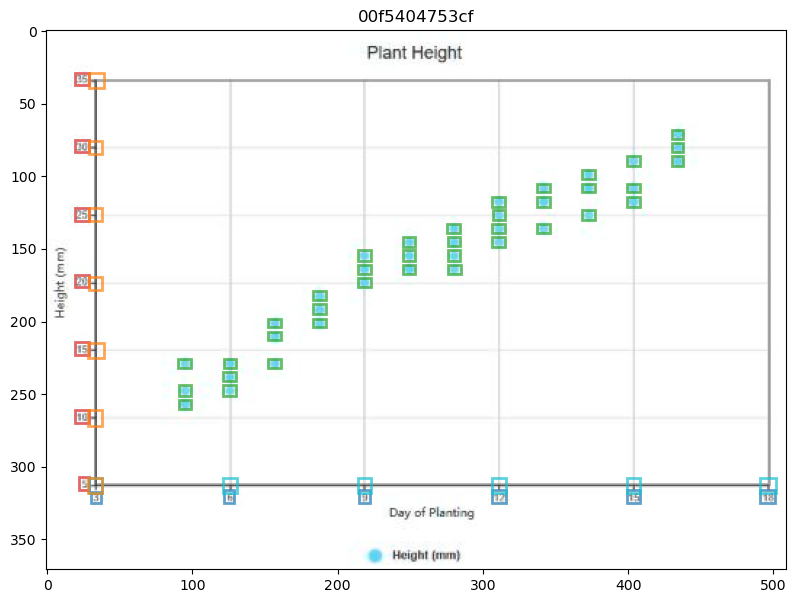

Scores  -  x: 1.000  - y: 0.997

-> Scatter CV : 0.998

-> Saved results to df_scatter_preds.csv


In [16]:
scores, preds_x, preds_y = [], {}, {}
for idx in range(len(df)):
    try:
        id_ = df.id[idx]
        print(idx, id_, end="\t")
        title = f"{id_}"
        preds = [[], [], [], []]

        # Update shapes
        img, _, _ = dataset[idx]

        if img.shape[1] > img.shape[0] * 1.4:
            padding_bot = int(img.shape[1] * 0.9) - img.shape[0]
        else:
            padding_bot = 0
        if img.shape[1] < img.shape[0] * 0.9:
            padding_r = int(img.shape[0] * 1) - img.shape[1]
        else:
            padding_r = 0

        meter.preds[idx].update_shape((img.shape[0] + padding_bot, img.shape[1] + padding_r))
        meter_2.preds[idx].update_shape((img.shape[0] + padding_bot, img.shape[1] + padding_r))

        # NMS
        preds_1 = [meter.preds[idx]['pascal_voc'][meter.labels[idx] == i] for i in range(len(config_marker.labels))]
        preds_2 = [meter_2.preds[idx]['pascal_voc'][meter_2.labels[idx] == i] for i in range(len(config_marker.labels))]

        scores_1 = [meter.confidences[idx][meter.labels[idx] == i] for i in range(len(config_marker.labels))]
        scores_2 = [meter_2.confidences[idx][meter_2.labels[idx] == i] for i in range(len(config_marker.labels))]

        try:
            boxes = np.concatenate([preds_1[0], preds_2[0]], 0)
            confs = np.concatenate([scores_1[0], scores_2[0]], 0)

            merged_boxes, merged_confs = nms(boxes, confs, threshold=0.4)
            preds_marker = merged_boxes.copy()
        except:
            print('NMS error')
            preds_marker = preds_2[0]

        preds[3] = preds_marker

        # Cached
        if len(preds[-1]):
            try:
                cached_result = inference_detector(cached_model, dataset.paths[idx])  # list[array]

                # Override with cached
                score_th = min(0.1, cached_result[4][2, 4])
                x_labels = cached_result[4][cached_result[4][:, -1] > score_th][:, :4].astype(int)

                score_th = min(0.1, cached_result[5][2, 4])
                y_labels = cached_result[5][cached_result[5][:, -1] > score_th][:, :4].astype(int)

                score_th = min(0.1, cached_result[7][2, 4])
                x_ticks = cached_result[7][cached_result[7][:, -1] > score_th][:, :4].astype(int)

                score_th = min(0.1, cached_result[8][2, 4])
                y_ticks = cached_result[8][cached_result[8][:, -1] > score_th][:, :4].astype(int)

                preds[0] = cached_result[2][:1, :4].astype(int)
                preds[1] = np.concatenate([x_labels, y_labels])
                preds[2] = np.concatenate([x_ticks, y_ticks])
            except:
                print('CACHED Error')
                pass

        try:
            preds = post_process_point_as_tick(
                preds, marker_conf=merged_confs, th=0.5, max_dist=4, max_dist_o=10, verbose=DEBUG
            )
        except:
            print('Error with post_process_point_as_tick')
            pass

        try:
            preds = post_process_preds(preds)
        except:
            print('Error with post_process_preds')
            pass

        try:
            preds = post_process_arrow(preds, verbose=1)
        except:
            print('Error with post_process_arrow')
            pass

        margin = (img.shape[0] + img.shape[1]) / (2 * 20)
        preds = restrict_on_line(preds, margin=margin)

        # Visual similarity
        try:
            retrieved_boxes = retrieve_missing_boxes(preds, img, verbose=False, min_sim=0.75, seed=0)
            if len(retrieved_boxes):
                preds[-1] = np.concatenate([preds[-1], retrieved_boxes])
        except:
            print('Error with retrieve_missing_boxes')
            pass

        if PLOT:
            plot_results(img, preds, figsize=(12, 7), title=title)

        # OCR
        score_x, score_y = -1, -1
        if len(preds[-1]):
            try:
                x_texts = ocr(ocr_model, processor, img, preds[1], margin=1, plot=DEBUG)
                x_values, x_errors = post_process_texts(x_texts)
                reg_x = linear_regression(preds[3], x_values, x_errors, preds[-1], mode="x", verbose=DEBUG)
                reg_x = np.round(reg_x, rounding(np.max(reg_x)))
            except:  # OCR or reg fail for x, use dummy values
                print("Error with x OCR")
                reg_x = np.arange(len(preds[-1]))

            try:
                y_texts = ocr(ocr_model, processor, img, preds[2], margin=3, plot=DEBUG)
                y_values, y_errors = post_process_texts(y_texts)
                reg_y = linear_regression(preds[4], y_values, y_errors, preds[-1], mode="y", verbose=DEBUG)
            except:
                print("Error with y OCR")
                reg_y = np.arange(len(preds[-1]))

            pred = pd.DataFrame({"x": reg_x, "y": reg_y})
            pred = pred.sort_values(['x', 'y'], ignore_index=True)
            preds_x[id_] = ";".join(pred['x'].astype(str))
            preds_y[id_] = ";".join(pred['y'].astype(str))

            gt = df_target[df_target['id'] == id_].reset_index(drop=True)
            if len(gt):
                gt[["x", "y"]] = gt[["x", "y"]].astype(float)
                gt = gt.sort_values(['x', 'y'], ignore_index=True)

                if id_ in FIXES:
                    gt["y"] = FIXES[id_]

                score_x = score_series(gt['x'].values, pred['x'].values)
                score_y = score_series(gt['y'].values, pred['y'].values)

        if id_ not in TO_REMOVE:
            scores += [max(0, score_x), max(0, score_y)]
            if score_x >= 0:
                print(f"Scores  -  x: {score_x:.3f}  - y: {score_y:.3f}")

    except:
        continue

    if DEBUG:
        break

if len(scores):
    if np.mean(scores):
        print(f'\n-> Scatter CV : {np.mean(scores) :.3f}')
    
df['pred_x'] = df['id'].apply(lambda x: preds_x.get(x, ""))
df['pred_y'] = df['id'].apply(lambda x: preds_y.get(x, ""))

df.to_csv('df_scatter_preds.csv', index=False)

print('\n-> Saved results to df_scatter_preds.csv')

### To submission format

In [17]:
df = pd.read_csv('pred_cls.csv')[['path', 'chart-type', "id"]]
# df['id'] = df['path'].apply(lambda x: x[:-4].split('/')[-1])

# Merge scatter
df_scatter = pd.read_csv('df_scatter_preds.csv')
df_scatter = df_scatter[['id', 'pred_x', 'pred_y']]

df = df.merge(df_scatter, on="id", how="left")

df['pred_x'] = df['pred_x'].fillna("")
df['pred_y'] = df['pred_y'].fillna("")

# Reformat & save
dfx = df[["id", "pred_x", "chart-type"]].copy()
dfx['id'] += "_x"
dfx.columns = ["id", "data_series", "chart_type"]

dfy = df[["id", "pred_y", "chart-type"]].copy()
dfy['id'] += "_y"
dfy.columns = ["id", "data_series", "chart_type"]

sub = pd.concat([dfx, dfy]).sort_values('id').reset_index(drop=True)

sub.to_csv('submission_scatter.csv', index=False)
print('-> Saved results to submission_scatter.csv')

display(sub[sub['chart_type'] == "scatter"].head())
sub.head(20)

-> Saved results to submission_scatter.csv


,id,data_series,chart_type
6,00f5404753cf_x,5.0;5.0;5.0;6.0;6.0;6.0;7.0;7.0;7.0;8.0;8.0;8....,scatter
7,00f5404753cf_y,11.017304917383424;12.038414700279155;14.02689...,scatter


,id,data_series,chart_type
0,000b92c3b098_x,,line
1,000b92c3b098_y,,line
2,007a18eb4e09_x,,line
3,007a18eb4e09_y,,line
4,00dcf883a459_x,,vertical_bar
5,00dcf883a459_y,,vertical_bar
6,00f5404753cf_x,5.0;5.0;5.0;6.0;6.0;6.0;7.0;7.0;7.0;8.0;8.0;8....,scatter
7,00f5404753cf_y,11.017304917383424;12.038414700279155;14.02689...,scatter
8,01b45b831589_x,,vertical_bar
9,01b45b831589_y,,vertical_bar


## Matcha

In [18]:
!pip install -qqq --no-index --find-links='/kaggle/input/transformers-deps' /kaggle/input/transformers-deps/transformers-4.30.0.dev0-py3-none-any.whl

import re
import torch
import warnings
import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path
from torch.utils.data import DataLoader
from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import yaml

warnings.filterwarnings("ignore", category=UserWarning)

data_dir = Path("/kaggle/input/benetech-making-graphs-accessible/test")
all_images = sorted((data_dir / "images").glob("*.jpg"))

if len(all_images) == 5:
    image_dir = Path("test/")
    all_images = list(image_dir.glob("*"))

# Remove already computed
sub_scatter = pd.read_csv('submission_scatter.csv').dropna(axis=0)
scatters = sub_scatter['id'].apply(lambda x: x[:-2]).unique()

sub_dot = pd.read_csv('submission_dot.csv').dropna(axis=0)
dots = sub_dot['id'].apply(lambda x: x[:-2]).unique()

image_paths = [
    img for img in all_images if
    ((img.stem not in scatters) and (img.stem not in dots))
]

image_ids = [img.stem for img in image_paths]

predict_df = pd.DataFrame(zip(image_ids, image_paths), columns=['id', 'image_path'])

In [19]:
MAX_LENGTH = 512

X_START = "<x_start>"
X_END = "<x_end>"
Y_START = "<y_start>"
Y_END = "<y_end>"

def string2preds(pred_string: str):

    if pred_string.startswith("<dot>"):
        chart_type = "dot"
    elif pred_string.startswith("<horizontal_bar>"):
        chart_type = "horizontal_bar"
    elif pred_string.startswith("<vertical_bar>"):
        chart_type = "vertical_bar"
    elif pred_string.startswith("<histogram>"):
        chart_type = "histogram"
    else:
        chart_type = "line"

    x = pred_string.split(X_START)[1].split(X_END)[0].strip().split(";")
    y = pred_string.split(Y_START)[1].split(Y_END)[0].strip().split(";")

    if len(x) == 0:
        x = []
    if len(y) == 0:
        y = []

    return chart_type, x, y

In [20]:
class MatchaModel(pl.LightningModule):
    def __init__(self, processor, model, max_length):

        super().__init__()
        self.processor = processor
        self.model = model
        self.max_length = max_length

    def predict_step(self, batch, batch_idx):
        ids, images = batch

        outputs = self.model.generate(**images, max_new_tokens=self.max_length)
        preds = self.processor.batch_decode(outputs, skip_special_tokens=True)

        return ids, preds

class PredictImageDataset(Dataset):
    def __init__(self, df, processor):

        self.processor = processor

        self.ids = df['id'].values
        self.image_paths = df['image_path'].values

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):

        img = Image.open(self.image_paths[idx])
        img = self.processor(img, return_tensors='pt')

        return self.ids[idx], img

class PredictCustomCollator():

    def __init__(self, pad_token_id):
        self.pad_token_id = pad_token_id

    def __call__(self, batch):
        ids, images = [], []

        for item in batch:
            ids.append(item[0])
            images.append(item[1])
        
        images = {
            "flattened_patches": torch.tensor(np.vstack([img['flattened_patches'] for img in images])),
            "attention_mask": torch.tensor(np.vstack([img['attention_mask'] for img in images])),
        }

        return ids, images
    
pred_loader_params = {
    'batch_size': 4,
    'drop_last': False,
    'num_workers': 2,
    'pin_memory': False,
    'shuffle': False,
}

class ImageDataModule(pl.LightningDataModule):
    def __init__(
        self,
        predict_df = None,
        processor = None,
    ):
        super().__init__()
        self.predict_df = predict_df
        self.processor = processor

    def setup(self, stage):
        self.predict_dataset = PredictImageDataset(self.predict_df, self.processor)

    def predict_dataloader(self):
        custom_collator = PredictCustomCollator(self.processor.tokenizer.pad_token_id)
        return DataLoader(self.predict_dataset, **pred_loader_params, collate_fn=custom_collator)

In [21]:
MODEL_DIR = '/kaggle/input/benetech-base-model'
model = Pix2StructForConditionalGeneration.from_pretrained(MODEL_DIR)
processor = Pix2StructProcessor.from_pretrained(MODEL_DIR)

matcha = MatchaModel(processor, model, MAX_LENGTH)
datamodule = ImageDataModule(predict_df=predict_df, processor=processor)

In [22]:
dict_paths = [
    "/kaggle/input/benetech-base-ckpts/10ep_3e-5_aug_2_extracted_7.ckpt",
    "/kaggle/input/benetech-base-ckpts/matcha_full_noisy.ckpt",
    "/kaggle/input/benetech-base-ckpts/10ep_3e-5_aug_1_extracted_5.ckpt",
    "/kaggle/input/benetech-base-ckpts/matcha_full_stable.ckpt",
    "/kaggle/input/benetech-base-ckpts/10ep_1e-5_aug_2_0_35_cosine_extracted_7.ckpt",
]

d, ct, xs, ys = {}, {}, {}, {}

first_pred = {}

for dict_path in dict_paths:
    
    preds, ids = [], []
    
    state_dict = torch.load(dict_path)['state_dict']
    
    for key in list(state_dict.keys()):
        state_dict[key[6:]] = state_dict.pop(key)
        
    matcha.model.load_state_dict(state_dict, strict=True)

    trainer = pl.Trainer(
        logger = False,
        accelerator = "gpu",
        devices = 1,
        precision = '16-mixed',
    )

    outputs = trainer.predict(matcha, datamodule=datamodule)
    
    for o in outputs:
        ids.extend(o[0])
        preds.extend(o[1])
        
        for curr_id, pred in zip(o[0],o[1]):
            if curr_id not in first_pred:
                first_pred[curr_id] = pred

    for curr_id, pred in zip(ids, preds):
        try:
            chart_type, x, y = string2preds(pred)

            if curr_id not in d:
                d[curr_id] = []

            """
            # use only categorical axis - more stable
            if chart_type == 'horizontal_bar':
                d[curr_id].append(len(y))
            else:
                d[curr_id].append(len(x))
            """
            
            d[curr_id].append(len(x))
            if chart_type == 'histogram':
                # ignore ys for hist - sometimes it mistakes it for vertical_bar
                #d[curr_id].append(len(y)+1)
                pass
            else:
                d[curr_id].append(len(y))

            if curr_id not in ct:
                ct[curr_id] = []
                xs[curr_id] = []
                ys[curr_id] = []

            ct[curr_id].append(chart_type)
            xs[curr_id].append(x)
            ys[curr_id].append(y)
                
        except:
            pass

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [23]:
def is_float(vals):
    try:
        vals = [float(x) for x in vals]
    except:
        return False
    return True

cnt = {}
for k, v in d.items():
    cnt[k] = max(v,key=v.count)

res_ids, chart_types, x_preds, y_preds = [], [], [], []

for curr_id in ct:
    c, x, y = ct[curr_id], xs[curr_id], ys[curr_id]

    if len(c) == 0:
        continue

    chart_type = max(c,key=c.count)
    
    hm = cnt[curr_id]
    x = [a for a in x if len(a) == hm]
    
    # sometimes it mistakes histograms with vertical_bars
    if chart_type == 'histogram' and any([a for a in y if len(a) == hm-1]):
        hm -= 1
        
    y = [a for a in y if len(a) == hm]

    if chart_type == 'horizontal_bar':
        x, y = y, x

    if len(x) == 0 or len(y) == 0:
        continue

    #best_x = max(x,key=x.count)
    best_x = []

    for i in range(len(x[0])):
        curr_x = [a[i] for a in x]
        best_x.append(max(curr_x,key=curr_x.count))
    """
    new_ys = []

    for xx, yy in zip(x, y):
        if xx != best_x:
            continue
        new_ys.append(yy)
    
    y = new_ys
    """
    y = [a for a in y if is_float(a)]

    if len(x) == 0 or len(y) == 0:
        continue

    y = [[float(a) for a in yy] for yy in y]
    
    y = np.vstack(y).mean(axis=0)

    x = best_x

    if chart_type == 'horizontal_bar':
        x, y = y, x

    x_str = ";".join(list(map(str, x)))
    y_str = ";".join(list(map(str, y)))
    
    res_ids.append(curr_id)
    chart_types.append(chart_type)
    x_preds.append(x_str)
    y_preds.append(y_str)

In [24]:
# fallback
ids_set = set(res_ids)
missing_ids = [curr_id for curr_id in predict_df['id'].values if curr_id not in ids_set]
        
for curr_id in missing_ids:
    try:
        chart_type, xs, ys = string2preds(first_pred[curr_id])
        x_str = ";".join(list(map(str, xs)))
        y_str = ";".join(list(map(str, ys)))
        
        res_ids.append(curr_id)
        chart_types.append(chart_type)
        x_preds.append(x_str)
        y_preds.append(y_str)       
    except:   
        res_ids.append(curr_id)
        chart_types.append('line')
        x_preds.append('0;0;0')
        y_preds.append('0;0;0')

In [25]:
#replace histograms with vertical bars
def fix_hist(vals):
    new_vals = []
    for v in vals:
        if v == 'histogram':
            new_vals.append('vertical_bar')
        else:
            new_vals.append(v)
    return new_vals

chart_types = fix_hist(chart_types)

In [26]:
sub_df = pd.DataFrame(
    data={
        "id": [f"{id_}_x" for id_ in res_ids] + [f"{id_}_y" for id_ in res_ids],
        "data_series": x_preds + y_preds,
        "chart_type": chart_types * 2,
    }
)

sub_df.to_csv("submission_matcha.csv", index=False)
print('-> Saved results to submission_matcha.csv')
sub_df.head(20)

-> Saved results to submission_matcha.csv


,id,data_series,chart_type
0,01b45b831589_x,21-Feb;22-Feb;23-Feb;24-Feb;25-Feb;26-Feb;27-F...,vertical_bar
1,00dcf883a459_x,Group 1;Group 2,vertical_bar
2,000b92c3b098_x,0;6;12;18;24,line
3,007a18eb4e09_x,0.0;0.4;0.8;1.2;1.6;2.0;2.4,line
4,01b45b831589_y,89075.4;150237.4;171357.6;176634.8;137062.6;98...,vertical_bar
5,00dcf883a459_y,3.66;8.44,vertical_bar
6,000b92c3b098_y,0.011;-0.68;-1.382;-2.082;-2.7448,line
7,007a18eb4e09_y,0.013277948000000001;0.013277828;0.01328279;0....,line


## Sub

In [27]:
dfy = pd.read_csv('pred_cls.csv')[['chart-type', "id"]]
dfx = dfy.copy()
dfx['id'] += "_x"
dfy['id'] += "_y"
sub = pd.concat([dfx, dfy], ignore_index=True).rename(columns={'chart-type': "chart_type"})

sub_scatter = pd.read_csv('submission_scatter.csv')[["id", "data_series"]]
sub_scatter = sub_scatter.dropna(axis=0)

sub_dot = pd.read_csv('submission_dot.csv')[["id", "data_series"]]
sub_dot = sub_dot.dropna(axis=0)

sub_matcha = pd.read_csv('submission_matcha.csv')[["id", "data_series"]]

results = pd.concat([sub_scatter, sub_dot, sub_matcha])
results = results.drop_duplicates(keep="last", subset="id")

sub = sub.merge(results, on="id")
sub = sub[["id", "data_series", "chart_type"]]
sub = sub.sort_values('id', ignore_index=True)

sub.to_csv('submission.csv', index=False)
print('-> Saved results to submission.csv')
sub.head(20)

-> Saved results to submission.csv


,id,data_series,chart_type
0,000b92c3b098_x,0;6;12;18;24,line
1,000b92c3b098_y,0.011;-0.68;-1.382;-2.082;-2.7448,line
2,007a18eb4e09_x,0.0;0.4;0.8;1.2;1.6;2.0;2.4,line
3,007a18eb4e09_y,0.013277948000000001;0.013277828;0.01328279;0....,line
4,00dcf883a459_x,Group 1;Group 2,vertical_bar
5,00dcf883a459_y,3.66;8.44,vertical_bar
6,00f5404753cf_x,5.0;5.0;5.0;6.0;6.0;6.0;7.0;7.0;7.0;8.0;8.0;8....,scatter
7,00f5404753cf_y,11.017304917383424;12.038414700279155;14.02689...,scatter
8,01b45b831589_x,21-Feb;22-Feb;23-Feb;24-Feb;25-Feb;26-Feb;27-F...,vertical_bar
9,01b45b831589_y,89075.4;150237.4;171357.6;176634.8;137062.6;98...,vertical_bar


Done !